In [15]:
import numpy as np
import pandas as pd 
import argparse  
import random
from sklearn.preprocessing import MinMaxScaler

from collections import deque
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import gc

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

In [16]:
print("tf version : ",tf.__version__)
!python --version

tf version :  2.8.0
Python 3.9.7


In [17]:
class PrioritizedBuffer:

    def __init__(self, max_size, alpha = 0.0001, beta = 0.4):
        self.sum_tree = SumTree(max_size)
        self.alpha = alpha
        self.beta = beta
        self.current_length = 0

    def push(self, state, action, reward, next_state, done):
        priority = 1.0 if self.current_length == 0 else self.sum_tree.tree.max()
        self.current_length = self.current_length + 1
        #priority = td_error ** self.alpha
        experience = (state, action, np.array([reward]), next_state, done)
        self.sum_tree.add(priority, experience)

    def sample(self, batch_size):
        batch_idx, batch, IS_weights = [], [], []
        segment = self.sum_tree.total() / batch_size
        p_sum = self.sum_tree.tree[0]

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            idx, p, data = self.sum_tree.get(s)

            batch_idx.append(idx)
            batch.append(data)
            prob = p / p_sum
            IS_weight = (self.sum_tree.total() * prob) ** (-self.beta)
            IS_weights.append(IS_weight)

        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        for transition in batch:
            state, action, reward, next_state, done = transition
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
#         print("y")
#         print(state_batch)
#         print("y")
        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch), batch_idx, IS_weights

    def update_priority(self, idx, td_error):
        priority = td_error ** self.alpha
        self.sum_tree.update(idx, priority)

    def __len__(self):
        return self.current_length

### SumTree


In [18]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros( 2*capacity - 1 )
        self.data = np.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

### Neural Network

In [19]:
class DQN(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.input_dim = input_dim # (96*1)
        self.output_dim = output_dim # (7)
        
#         self.fc = nn.Sequential(
#             nn.Linear(self.input_dim[0], 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256,self.output_dim)
#         )
        self.fc1=nn.Linear(self.input_dim[0],128)
        self.fc2=nn.Linear(128,256)
        self.fc3=nn.Linear(256,self.output_dim)

    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

### Agent

In [20]:
class PERAgent:

    def __init__(self,state,args):
        self.num_agents = args['agent_number']
        self.num_uav = args['uav_number']
        self.state_size = 3*(self.num_uav) + 6
        self.action_size = self.num_uav + 2
        self.buffer_size = 4000
        self.learning_rate = 0.0001
        self.input_shape=(self.state_size,)
        self.gamma = 0.7
        self.replay_buffer = PrioritizedBuffer(self.buffer_size)
        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = "cuda"
        self.model = DQN((self.state_size,), self.action_size).to(self.device)
          
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.MSE_loss = nn.MSELoss()

    def get_action(self, state, eps=0.0):
        tmp=torch.tensor(state,dtype=torch.float32)
        qvals = self.model.forward(tmp)
        action = np.argmax(qvals.cpu().detach().numpy())
        
        if(np.random.rand() > eps):
            return random.randrange(-1,args['uav_number']+1)
          
        return action

    def _sample(self, batch_size):
        return self.replay_buffer.sample(batch_size)

    def _compute_TDerror(self, batch_size):
        transitions, idxs, IS_weights = self._sample(batch_size)
        states, actions, rewards, next_states, dones = transitions
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        IS_weights = torch.FloatTensor(IS_weights).to(self.device)
        
        Q_vals = self.model.forward(states) 
#         print("Q_vals.size=")
#         print(Q_vals.size()) # [50,30,7]
#         print(actions.size()) # [50,30]
#         print(states.size()) # [50,30,21]
        curr_Q = Q_vals.gather(1, actions.unsqueeze(1)+1)
        
#         print(curr_Q.size()) # [50,1,30]
#         print(actions.size()) # [50,30]
        
        curr_Q = curr_Q.squeeze(1)
#         print(curr_Q.size()) # [50,30]
        
        next_Q = self.model.forward(next_states)
        max_next_Q = torch.max(next_Q, 1)[0]
        
#         print(rewards.size()) # [50,1] batch size
#         print(next_Q.size()) # [50,30,30]
#         print(max_next_Q.size()) # [50,30]
        
        expected_Q = rewards.squeeze(1) + self.gamma * max_next_Q
        td_errors = torch.pow(curr_Q - expected_Q, 2) * IS_weights

        return td_errors, idxs

    def update(self, batch_size):
        td_errors, idxs = self._compute_TDerror(batch_size)

        # update model
        td_errors_mean = td_errors.mean()
        self.optimizer.zero_grad()
        td_errors_mean.backward()
        self.optimizer.step()

        # update priorities
        for idx, td_error in zip(idxs, td_errors.cpu().detach().numpy()):
            self.replay_buffer.update_priority(idx, td_error)


### Maths

In [21]:
import math
class Maths(object):
    
    def __init__(self,args):
        
        self.num_agents = args['agent_number']
        self.num_uav = args['uav_number']
        self.grid_width = args['grid_width']
        self.uav_height = args['uav_height']
        self.uav_range = args['uav_range']
        self.local_compute = args['local_compute']
        self.uav_compute = args['uav_compute']
        self.cloud_compute = args['cloud_compute']
        self.reference_distance = args['reference_distance']
        self.los_channel_power = args['los_channel_power']
        self.uav_bandwidth = args['uav_bandwidth']
        self.cloud_bandwidth = args['cloud_bandwidth']
        self.uav_power = args['uav_power']
        self.cloud_power = args['cloud_power']
        self.noise_power = args['noise_power']
        self.propagation_time_factor = args['propagation_time_factor']
        self.local_energy_consumption_factor = args['local_energy_consumption_factor']
        self.punishment_factor = args['punishment_factor']
        self.cloud_channel_gain = args['cloud_channel_gain']   # H(t) used in equation 6 
    
    
    
    def uav_channel_gain(self, uav_pos, iiot_pos):
        
        a, b = uav_pos, iiot_pos
    
        distance = ((a[0]-b[0])**2 + (a[1]-b[1])**2)**(1/2)
        
        h_channel_condition = self.los_channel_power / ((self.uav_height**2) + (distance)**2)
        
        return h_channel_condition
    
    
    
    
    
    def uav_computation_time(self, uav_pos, iiot_pos, task_size, cpu_cycle):
        
        self.h_channel_condition = self.uav_channel_gain(uav_pos, iiot_pos)
        
        v1 = 1 + ((self.uav_power * self.h_channel_condition) / (self.noise_power) )    # value for log 
        uplink_transmission_rate = self.uav_bandwidth * (math.log(v1, 2))               # [equation - 5]  
        
        transmission_time = task_size / uplink_transmission_rate     # [equation -7]
        
        computation_time = cpu_cycle / self.uav_compute     #[equation -11] 
        
        execution_time = transmission_time + computation_time   
        
        return  execution_time
    
    
    
    
    
    def cloud_transmission_time(self, task_size):
        
        v1 = 1 + ((self.cloud_power * self.cloud_channel_gain) / (self.noise_power) ) 
        
        uplink_transmission_rate = self.cloud_bandwidth * (math.log(v1, 2))   #[equation -6]
        
        transmission_time = (task_size / uplink_transmission_rate) + self.propagation_time_factor     # [equation -8]

        return transmission_time
    
    
    def local_computation_time(self, cpu_cycle):
        
        local_computation_time = cpu_cycle / self.local_compute    # [equation-9]
    
        return local_computation_time
        
      

    
    def uav_energy_consumption(self, uav_pos, iiot_pos, task_size, cpu_cycle):
        
        execution_time= self.uav_computation_time(uav_pos, iiot_pos, task_size, cpu_cycle)           
                   
        uav_energy = self.uav_power * (execution_time)   #[equation -12]
    
        return uav_energy
    

    
    
    def cloud_energy_consumption(self, task_size):
         
        transmission_time = self.cloud_transmission_time( task_size)
        cloud_energy = self.cloud_power * (transmission_time + self.propagation_time_factor)   #[equation - 13]
        
        return cloud_energy
                   
      
    
    
    
    
    def local_energy_consumption(self, cpu_cycle):
       
        local_energy_consumption = self.local_energy_consumption_factor * (cpu_cycle ** 2)   #[equation - 10]
        
        return local_energy_consumption      
    
                   
        

### Environment() 


In [22]:


class Environment(object):
    
    def __init__(self,args):
        self.num_agents = args['agent_number']
        self.num_uav = args['uav_number']
        self.grid_width = args['grid_width']
        self.uav_height = args['uav_height']
        self.uav_range = args['uav_range']

        self.task_size, self.cpu_cycle, self.tolerant_delay = self.task_model()
        
        self.action_space = np.arange(-1, self.num_uav+1)   # action_space = {-1, 0, 1, ...., N}
        
        self.users_observation = np.zeros([self.num_agents], np.int32)
        self.state_size = 3*(self.num_uav) + 6 
        self.action_size = self.num_agents  
       
        self.UAVs_pos = self.UAVs_Position()
        self.iiot_pos=self.IIots_Position() 
        
        self.Maths = Maths(args)
        
     
    
    
    def task_model(self):
        
        task_size = random.sample(range(100, 80000), self.num_agents)   # task_size is taken in "Kb".
        cpu_cycle = random.sample(range(500000, 5000000000), self.num_agents)
        tolerant_delay = [round(random.uniform(0.1, 1),7) for i in range(self.num_agents)]
        
        return task_size, cpu_cycle, tolerant_delay
    
    
    
    
    
    
    def UAVs_Position(self):
        
        UAVs_pos = {}
        x = random.sample(range(self.grid_width),self.num_uav)
        y = random.sample(range(self.grid_width),self.num_uav)
        
        for i in range(1,self.num_uav+1):
            
            point = [x[i-1],y[i-1],self.uav_height]
            UAVs_pos[i] = point
            
        return  UAVs_pos    # list of uav_positions (with [x,y,z] coordinates)
    
     
        
        
        
    def IIots_Position(self):
            
        iiot_pos = {}  
        
        for i in range(self.num_agents):
            
            x = random.randint(1, self.grid_width) # Why Integers???? (YM)
            y = random.randint(1, self.grid_width)
            point = (x,y)
            iiot_pos[i] = point   # list of iiot_positions 
            
        return iiot_pos 
    
    
    
    
    
    def state(self):   
        
        uav_pos = [self.UAVs_pos[i] for i in range(1, self.num_uav+1)]
        l = []
        for i in uav_pos:
            
            l.append(i[0])
            l.append(i[1])
            
        all_states = []
        for i in range(self.num_agents):

            state = [self.task_size[i], self.cpu_cycle[i], self.tolerant_delay[i], self.iiot_pos[i][0], self.iiot_pos[i][1]]
            state.extend(l)
            state.append(args['cloud_channel_gain']) #H_i(t)
            h_channel_condition = [self.Maths.uav_channel_gain(j, self.iiot_pos[i]) for j in uav_pos]
            state.extend(h_channel_condition)
            
            all_states.append(state)
            
            #state.shape() = (3N+6,1)
        
        return  all_states    
         
      
    
    
    
    
    def next_state(self,x):
        
        task_size, cpu_cycle, tolerant_delay = self.task_model()
        uav_pos = [self.UAVs_pos[i] for i in range(1, self.num_uav+1)]
        iiot_pos = self.IIots_Position()
        
        l = []  
        for i in range(self.num_uav):
            
            if uav_pos[i][0] + 30 <= self.grid_width:            # since uavs are moving with some speed in fixed area so taking it as 30.
                
                l.append(uav_pos[i][0]+30)
                uav_pos[i][0] = uav_pos[i][0]+30
                
            else: 
                
                l.append(uav_pos[i][0])
               
            
            if uav_pos[i][1] + 30 <= self.grid_width:
                
                l.append(uav_pos[i][1] + 30)
                uav_pos[i][1] = uav_pos[i][1]+30
                
            else: 
                
                l.append( uav_pos[i][1] )

        next_state = [task_size[x], cpu_cycle[x], tolerant_delay[x], iiot_pos[x][0], iiot_pos[x][1]]
        next_state.extend(l)
        next_state.append(args['cloud_channel_gain'])
        h_channel_condition = [self.Maths.uav_channel_gain(j, iiot_pos[x]) for j in uav_pos]
        next_state.extend(h_channel_condition)
        
        return  next_state
         
      
    
    
    
    def reward_calculate(self, execution_time, energy_consumption, tolerant_delay):
        
        if execution_time <= tolerant_delay: 
            
            return 1/energy_consumption,  energy_consumption
        
        else:
            
            return (1/energy_consumption)* args['punishment_factor'] , energy_consumption
        
        
        
        
        
    def reward(self, agent_action, uav_pos, iiot_pos,task_size, cpu_cycle, tolerant_delay): 
        
        if agent_action == -1:   # offload to cloud
            
            execution_time = self.Maths.cloud_transmission_time(task_size)
            energy_consumption = self.Maths.cloud_energy_consumption(task_size)
            reward, energy_consumption = self.reward_calculate(execution_time, energy_consumption, tolerant_delay)
#             reward_sum = sum(reward)
            return reward, energy_consumption
        
        elif agent_action == 0:  # compute locally
            
            execution_time = self.Maths.local_computation_time(cpu_cycle)
            energy_consumption = self.Maths.local_energy_consumption(cpu_cycle)
            reward, energy_consumption= self.reward_calculate(execution_time, energy_consumption, tolerant_delay)
            
            return reward, energy_consumption
        
        else: # offload to UAV
            
            execution_time = self.Maths.uav_computation_time(uav_pos, iiot_pos, task_size, cpu_cycle)
            energy_consumption = self.Maths.uav_energy_consumption(uav_pos, iiot_pos, task_size, cpu_cycle)
            reward, energy_consumption= self.reward_calculate(execution_time, energy_consumption, tolerant_delay)
            
            return reward, energy_consumption
    
    
    def done(self, act,i):
        
        done = False

        if act> 0 :  #uav task 

            a, b = self.UAVs_pos[act], self.iiot_pos[i]
            distance = ((a[0]-b[0])**2 + (a[1]-b[1])**2)**(1/2)
            execution_time = self.Maths.uav_computation_time( self.UAVs_pos[act], self.iiot_pos[i], self.task_size[i], self.cpu_cycle[i])

            if (execution_time <= self.tolerant_delay[i]) and (distance <= args['uav_range']):

                done = False

            else :

                done = True

        elif act == 0:  # compute_locally

            execution_time = self.Maths.local_energy_consumption(self.cpu_cycle[i])

            if execution_time <= self.tolerant_delay[i] :

                done = False

            else: 

                done = True

        else : # cloud task 

            execution_time = self.Maths.cloud_transmission_time(self.task_size[i])
            if execution_time <= self.tolerant_delay[i]:

                done = False 

            else:

                done = True 
         
        return done
    
                
             
    
    
    
    
    def step(self, act, i):  
        if act > 0: # Task offloaded to UAV

            r, e_c = self.reward(act, self.UAVs_pos[act], self.iiot_pos[i], self.task_size[i], self.cpu_cycle[i], self.tolerant_delay[i])

        elif act == 0: # Task executed locally

            r, e_c= self.reward(act, [0,0,0],(0,0),self.task_size[i], self.cpu_cycle[i], self.tolerant_delay[i])

        else : # Task offloaded to Cloud

            r, e_c = self.reward(act, [0,0,0],(0,0),self.task_size[i], self.cpu_cycle[i], self.tolerant_delay[i])
        
        done = self.done(act,i)   
        next_state = self.next_state(i)    

        return next_state, r, e_c, done, self.task_size, self.cpu_cycle, self.tolerant_delay
                    
        
        
        
            
    def reset(self):
        
        self.UAV_Pos()
        self.IIOT_Pos()
             

### ENV  

In [23]:
class ENV(object):
    def __init__(self, args):
        
        self.step_b_update = args['step_b_update']
        self.ep = args['episodes']
        self.bs = args['batch_size']
        
        
    def main(self):
        
        total_step = 0
        for episode in range(self.ep): 
            
            print("mdspr")
            print(f"--------------\n1. Number of iiot devices : {args['agent_number']}")
            print(f"2. Total Training steps : {args['max_timesteps']}\n\n\n")
    
           
            time_step = 0
            all_loss = []
            all_done=[]
            all_rewards = []
            all_actions = []
            all_energy_consumption=[]
            all_task_size = []
            all_cpu_cycle=[]
            all_tolerant_delay=[]
            env = Environment(args) # Initialise Environment
            state = env.state()  # Get Initial State
            agent = PERAgent(state,args)
            
            while time_step < args['max_timesteps']:
                
                print("Training Step : ", time_step, "\n")
                
                actions = []   
                rew = 0
                for i in range(args['agent_number']):
                    # Get Actions based on ep-Greedy
                    t = torch.tensor(state[i],dtype=torch.float32)
                    cur_action = agent.get_action(t)
                    actions.append(cur_action) 
                    
                    # Get Next State, Reward etc.
                    next_state, reward,energy_consumption, done,  task_size, cpu_cycle, tolerant_delay = env.step(cur_action,i)

                    # Store Experience with random (not now) priority
                    state1 = np.array(state[i])
                    agent.replay_buffer.push(state1, cur_action, reward, next_state, done)
                    state[i] = next_state
                    rew+=reward

                
                print("Actions taken each timestep = ")
#                 print(actions)
                
                # Use the Experience
#                 print(self.bs)
#                 print(len(agent.replay_buffer))
                if len(agent.replay_buffer) > self.bs:
                    print("Updating")
                    agent.update(self.bs)   

                if time_step == args['max_timesteps']-1:
                    break

        
                all_task_size.append(task_size)
                all_cpu_cycle.append(cpu_cycle)
                all_tolerant_delay.append(tolerant_delay)
                all_energy_consumption.append(energy_consumption)
                all_actions.append(actions)
                all_rewards.append(rew)
                all_done.append(done)
                
                time_step +=1
                total_step +=1
                
            print("\n","*"*110,"\n"*5)
            
            
            return all_loss, all_energy_consumption, all_done, all_rewards, all_actions, all_task_size, all_cpu_cycle, all_tolerant_delay
        
            
            
            

In [24]:
if __name__ == "__main__":
    
    for i in [30]:
        parser = argparse.ArgumentParser()


        parser.add_argument("-f")
        parser.add_argument("-lr", "--learning_rate", default=0.0001, type=float, help="learning rate")
        parser.add_argument("-tf", "--target_frequency", default=50, type=int, help="target weights replace steps") # in paper 500
        parser.add_argument("-bs", "--batch_size", default=50, type=int, help="batch size")
        parser.add_argument("-ga", "--gamma", default=0.7, type=float, help="reward decay rate")
        parser.add_argument("-e", "--epsilon", default=0.9, type=float, help="exploration rate")
        parser.add_argument("-c", "--memory_capacity", default= 10000, type=int, help="replay memory capacity")
        parser.add_argument("-nn", "--number_nodes", default=100, type=int, help="number of nodes in each layer of neural network")
        parser.add_argument("-m", "--agent_number", default=30, type=int, help="total number of iiot devices")  # 1000 used in paper 
        parser.add_argument("-uav", "--uav_number", default=5, type=int, help="total number of UAVs")
        parser.add_argument("-g", "--grid_width", default=800, type=int, help="size of fixed area under consideration")
        parser.add_argument("-H", "--uav_height" , default=100, type=int, help="flying height of UAV  'in meters'")
        parser.add_argument("-r", "--uav_range", default=300, type=int, help="communication range of UAV 'in meters'")
        parser.add_argument("-cl", "--local_compute", default=500e+6, type=float, help="local computation capacity 'cycle/second'")  # 500MHz
        parser.add_argument("-cu", "--uav_compute", default=2e+9, type=float, help="UAV compution capacity 'cycle/second'")  # 2GHz
        parser.add_argument("-cc", "--cloud_compute", default=100e+9, type=float, help="cloud computation capacity 'cycle/second'")  #  100GHz
        parser.add_argument("-rd", "--reference_distance", default=1, type=float, help="channel gain reference distance 'meters'")
        parser.add_argument("-lcp", "--los_channel_power", default=1.42e-4, type=float, help="channel gain at the reference")
        parser.add_argument("-ub", "--uav_bandwidth", default=15e+6, type=float, help="bandwidth allocated for UAV uplin transmission rate 'cycles/second'")  # 15MHz
        parser.add_argument("-cb", "--cloud_bandwidth", default=10e+6, type=float, help="bandwidth allocated for cloud uplink transmission 'cycles/second'")  #  10MHz
        parser.add_argument("-up","--uav_power", default=0.01, type=float, help="uplink transmission power for UAV offloading  'W'")
        parser.add_argument("-cp", "--cloud_power", default=0.015, type=float, help="uplink transmission power for cloud offloading  'W'")
        parser.add_argument("-n", "--noise_power", default=1e-12, type=float, help="background noise power  'Watt-second'") # -90 dBm/Hz
        parser.add_argument("-ptf", "--propagation_time_factor", default=3.2e-5, type=float, help="uplink propogation delay factor  's/Kb'")  # 4e-9 s/bit
        parser.add_argument("-lec", "--local_energy_consumption_factor", default=1e-23, type=float, help="local energy consumption factor 'theta' J/cycle")


          # value not given in paper
          #------------------------------------------------------------------------------------------------------------------------------------
        parser.add_argument("-ccg","--cloud_channel_gain", default=280.141199827, type=float, help="cloud channel gain H(t)")
        parser.add_argument("-b_stp", "--step_b_update",default=400, type=int, help="steps between updating the network")
        parser.add_argument("-pf", "--punishment_factor", default=0.0001, type = float, help="if tolerant delay < energy consumption")  
        parser.add_argument("-p", "--priority_scale", default=0.5, type=float, help="scale for prioritization")  
        parser.add_argument("-m_e", "--min_epsilon", default=0.02, type=float, help="minimum value of exploration rate")
        parser.add_argument("-e_d", "--epsilon_decay", default=1e-4, type=float, help="exploration decay rate")
        parser.add_argument('-m_b', "--min_beta", default=0.4, type=float, help="minimum value of importance sampling")
        parser.add_argument("-b_d","--beta_increment", default=1e-4, type=float, help="for incrementing beta value")
        parser.add_argument("-b_max", "--beta_max", default=0.9, type=float, help="incrementing value of importance sampling beta")
        parser.add_argument("-ts", "--max_timesteps", default=1000, type=int, help="maximum timesteps in each epsisode")  ## value not given in paper
        parser.add_argument("-ed", "--episodes", default=1, type=int, help="total number of episodes")    ## value not given in paper 

        parser.add_argument("-mt", "--memory_type", choices=['uer', 'per'], default="uer", help="per: prioritised experience replay, uer: uniform experience replay")
        parser.add_argument('-ddqn', "--double_dqn", choices=['dqn',"double_dqn"], default="double_dqn", help ="double deep Q network or DQN ")
        parser.add_argument("-dueling","--dueling", default=False, type=bool, help="Dueling option")
          #-------------------------------------------------------------------------------------------------------------------------------------

        # cloud_channel_gain = 148.1 + 40 ∗ log10 distance(km)   (taking distance as 20Km)  = 148.1 + 40* (log10 2000)


        args = vars(parser.parse_args())

        env = ENV(args)

        all_loss, all_energy_consumption, all_done, all_reward, all_action, all_task_size, all_cpu_cycle, all_tolerant_delay = env.main()

        df_loss = pd.DataFrame(all_loss)
        df_sum = df_loss.sum(axis=0).to_frame()
        df_energy_consumption = pd.DataFrame(all_energy_consumption) 
        df_done = pd.DataFrame(all_done)
        df_reward = pd.DataFrame(all_reward)
        df_action = pd.DataFrame(all_action)
        df_task_size=pd.DataFrame(all_task_size)
        df_cpu_cycle=pd.DataFrame(all_cpu_cycle)
        df_tolerant_delay=pd.DataFrame(all_tolerant_delay)
        

#         df_loss.to_csv("datasets/fig_8/xyz_md2spr_df_loss.csv")
#         df_energy_consumption.to_csv("datasets/fig_8/xyz_md2spr_df_energy_consumption.csv")
#         df_done.to_csv("datasets/fig_8/xyz_md2spr_df_done.csv")
#         df_reward.to_csv("datasets/fig_8/xyz_md2spr_reward.csv")
#         df_action.to_csv("datasets/fig_8/xyz_md2spr_df_action.csv")
#         df_task_size.to_csv("datasets/fig_8/xyz_md2spr_df_task_size.csv")
#         df_cpu_cycle.to_csv("datasets/fig_8/xyz_md2spr_df_task_size.csv")
#         df_tolerant_delay.to_csv("datasets/fig_8/xyz_md2spr_df_task_size.csv")


mdspr
--------------
1. Number of iiot devices : 30
2. Total Training steps : 1000



Training Step :  0 

Actions taken each timestep = 
Training Step :  1 

Actions taken each timestep = 
Updating
Training Step :  2 

Actions taken each timestep = 
Updating
Training Step :  3 

Actions taken each timestep = 
Updating
Training Step :  4 

Actions taken each timestep = 
Updating
Training Step :  5 

Actions taken each timestep = 
Updating


C:\Users\91784\AppData\Local\Temp/ipykernel_18540/3847101446.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp=torch.tensor(state,dtype=torch.float32)


Training Step :  6 

Actions taken each timestep = 
Updating
Training Step :  7 

Actions taken each timestep = 
Updating
Training Step :  8 

Actions taken each timestep = 
Updating
Training Step :  9 

Actions taken each timestep = 
Updating
Training Step :  10 

Actions taken each timestep = 
Updating
Training Step :  11 

Actions taken each timestep = 
Updating
Training Step :  12 

Actions taken each timestep = 
Updating
Training Step :  13 

Actions taken each timestep = 
Updating
Training Step :  14 

Actions taken each timestep = 
Updating
Training Step :  15 

Actions taken each timestep = 
Updating
Training Step :  16 

Actions taken each timestep = 
Updating
Training Step :  17 

Actions taken each timestep = 
Updating
Training Step :  18 

Actions taken each timestep = 
Updating
Training Step :  19 

Actions taken each timestep = 
Updating
Training Step :  20 

Actions taken each timestep = 
Updating
Training Step :  21 

Actions taken each timestep = 
Updating
Training Ste

C:\Users\91784\AppData\Local\Temp/ipykernel_18540/95596297.py:12: RuntimeWarning: overflow encountered in double_scalars
  self.tree[parent] += change
C:\Users\91784\AppData\Local\Temp/ipykernel_18540/2589911338.py:22: RuntimeWarning: invalid value encountered in double_scalars
  a = segment * i
C:\Users\91784\AppData\Local\Temp/ipykernel_18540/2589911338.py:31: RuntimeWarning: invalid value encountered in double_scalars
  IS_weight = (self.sum_tree.total() * prob) ** (-self.beta)


Actions taken each timestep = 
Updating
Training Step :  43 

Actions taken each timestep = 
Updating
Training Step :  44 

Actions taken each timestep = 
Updating
Training Step :  45 

Actions taken each timestep = 
Updating
Training Step :  46 

Actions taken each timestep = 
Updating
Training Step :  47 

Actions taken each timestep = 
Updating
Training Step :  48 

Actions taken each timestep = 
Updating
Training Step :  49 

Actions taken each timestep = 
Updating
Training Step :  50 

Actions taken each timestep = 
Updating
Training Step :  51 

Actions taken each timestep = 
Updating
Training Step :  52 

Actions taken each timestep = 
Updating
Training Step :  53 

Actions taken each timestep = 
Updating
Training Step :  54 

Actions taken each timestep = 
Updating
Training Step :  55 

Actions taken each timestep = 
Updating
Training Step :  56 

Actions taken each timestep = 
Updating
Training Step :  57 

Actions taken each timestep = 
Updating
Training Step :  58 

Actions 

Actions taken each timestep = 
Updating
Training Step :  176 

Actions taken each timestep = 
Updating
Training Step :  177 

Actions taken each timestep = 
Updating
Training Step :  178 

Actions taken each timestep = 
Updating
Training Step :  179 

Actions taken each timestep = 
Updating
Training Step :  180 

Actions taken each timestep = 
Updating
Training Step :  181 

Actions taken each timestep = 
Updating
Training Step :  182 

Actions taken each timestep = 
Updating
Training Step :  183 

Actions taken each timestep = 
Updating
Training Step :  184 

Actions taken each timestep = 
Updating
Training Step :  185 

Actions taken each timestep = 
Updating
Training Step :  186 

Actions taken each timestep = 
Updating
Training Step :  187 

Actions taken each timestep = 
Updating
Training Step :  188 

Actions taken each timestep = 
Updating
Training Step :  189 

Actions taken each timestep = 
Updating
Training Step :  190 

Actions taken each timestep = 
Updating
Training Step :

Training Step :  306 

Actions taken each timestep = 
Updating
Training Step :  307 

Actions taken each timestep = 
Updating
Training Step :  308 

Actions taken each timestep = 
Updating
Training Step :  309 

Actions taken each timestep = 
Updating
Training Step :  310 

Actions taken each timestep = 
Updating
Training Step :  311 

Actions taken each timestep = 
Updating
Training Step :  312 

Actions taken each timestep = 
Updating
Training Step :  313 

Actions taken each timestep = 
Updating
Training Step :  314 

Actions taken each timestep = 
Updating
Training Step :  315 

Actions taken each timestep = 
Updating
Training Step :  316 

Actions taken each timestep = 
Updating
Training Step :  317 

Actions taken each timestep = 
Updating
Training Step :  318 

Actions taken each timestep = 
Updating
Training Step :  319 

Actions taken each timestep = 
Updating
Training Step :  320 

Actions taken each timestep = 
Updating
Training Step :  321 

Actions taken each timestep = 
U

Training Step :  437 

Actions taken each timestep = 
Updating
Training Step :  438 

Actions taken each timestep = 
Updating
Training Step :  439 

Actions taken each timestep = 
Updating
Training Step :  440 

Actions taken each timestep = 
Updating
Training Step :  441 

Actions taken each timestep = 
Updating
Training Step :  442 

Actions taken each timestep = 
Updating
Training Step :  443 

Actions taken each timestep = 
Updating
Training Step :  444 

Actions taken each timestep = 
Updating
Training Step :  445 

Actions taken each timestep = 
Updating
Training Step :  446 

Actions taken each timestep = 
Updating
Training Step :  447 

Actions taken each timestep = 
Updating
Training Step :  448 

Actions taken each timestep = 
Updating
Training Step :  449 

Actions taken each timestep = 
Updating
Training Step :  450 

Actions taken each timestep = 
Updating
Training Step :  451 

Actions taken each timestep = 
Updating
Training Step :  452 

Actions taken each timestep = 
U

Actions taken each timestep = 
Updating
Training Step :  572 

Actions taken each timestep = 
Updating
Training Step :  573 

Actions taken each timestep = 
Updating
Training Step :  574 

Actions taken each timestep = 
Updating
Training Step :  575 

Actions taken each timestep = 
Updating
Training Step :  576 

Actions taken each timestep = 
Updating
Training Step :  577 

Actions taken each timestep = 
Updating
Training Step :  578 

Actions taken each timestep = 
Updating
Training Step :  579 

Actions taken each timestep = 
Updating
Training Step :  580 

Actions taken each timestep = 
Updating
Training Step :  581 

Actions taken each timestep = 
Updating
Training Step :  582 

Actions taken each timestep = 
Updating
Training Step :  583 

Actions taken each timestep = 
Updating
Training Step :  584 

Actions taken each timestep = 
Updating
Training Step :  585 

Actions taken each timestep = 
Updating
Training Step :  586 

Actions taken each timestep = 
Updating
Training Step :

Training Step :  706 

Actions taken each timestep = 
Updating
Training Step :  707 

Actions taken each timestep = 
Updating
Training Step :  708 

Actions taken each timestep = 
Updating
Training Step :  709 

Actions taken each timestep = 
Updating
Training Step :  710 

Actions taken each timestep = 
Updating
Training Step :  711 

Actions taken each timestep = 
Updating
Training Step :  712 

Actions taken each timestep = 
Updating
Training Step :  713 

Actions taken each timestep = 
Updating
Training Step :  714 

Actions taken each timestep = 
Updating
Training Step :  715 

Actions taken each timestep = 
Updating
Training Step :  716 

Actions taken each timestep = 
Updating
Training Step :  717 

Actions taken each timestep = 
Updating
Training Step :  718 

Actions taken each timestep = 
Updating
Training Step :  719 

Actions taken each timestep = 
Updating
Training Step :  720 

Actions taken each timestep = 
Updating
Training Step :  721 

Actions taken each timestep = 
U

Training Step :  838 

Actions taken each timestep = 
Updating
Training Step :  839 

Actions taken each timestep = 
Updating
Training Step :  840 

Actions taken each timestep = 
Updating
Training Step :  841 

Actions taken each timestep = 
Updating
Training Step :  842 

Actions taken each timestep = 
Updating
Training Step :  843 

Actions taken each timestep = 
Updating
Training Step :  844 

Actions taken each timestep = 
Updating
Training Step :  845 

Actions taken each timestep = 
Updating
Training Step :  846 

Actions taken each timestep = 
Updating
Training Step :  847 

Actions taken each timestep = 
Updating
Training Step :  848 

Actions taken each timestep = 
Updating
Training Step :  849 

Actions taken each timestep = 
Updating
Training Step :  850 

Actions taken each timestep = 
Updating
Training Step :  851 

Actions taken each timestep = 
Updating
Training Step :  852 

Actions taken each timestep = 
Updating
Training Step :  853 

Actions taken each timestep = 
U

Training Step :  970 

Actions taken each timestep = 
Updating
Training Step :  971 

Actions taken each timestep = 
Updating
Training Step :  972 

Actions taken each timestep = 
Updating
Training Step :  973 

Actions taken each timestep = 
Updating
Training Step :  974 

Actions taken each timestep = 
Updating
Training Step :  975 

Actions taken each timestep = 
Updating
Training Step :  976 

Actions taken each timestep = 
Updating
Training Step :  977 

Actions taken each timestep = 
Updating
Training Step :  978 

Actions taken each timestep = 
Updating
Training Step :  979 

Actions taken each timestep = 
Updating
Training Step :  980 

Actions taken each timestep = 
Updating
Training Step :  981 

Actions taken each timestep = 
Updating
Training Step :  982 

Actions taken each timestep = 
Updating
Training Step :  983 

Actions taken each timestep = 
Updating
Training Step :  984 

Actions taken each timestep = 
Updating
Training Step :  985 

Actions taken each timestep = 
U

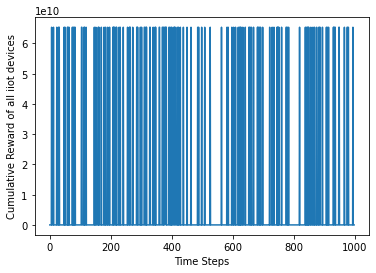

NameError: name 'df_energy_consumption1' is not defined

In [27]:
import matplotlib.pyplot as plt
# print(df_sum)
# plt.plot(df_sum1)
# plt.xlabel("Time Steps")
# plt.ylabel("Cumulative Loss of all iiot devices")
# plt.show()
plt.plot(df_reward)
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward of all iiot devices")
plt.show()
plt.plot(df_energy_consumption1)
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Energy Consumption of all iiot devices")
plt.show()

In [252]:
print(df_reward)

                0
0    4.588520e+06
1    2.516332e+06
2    9.589136e+05
3    3.229045e+06
4    1.197047e+06
..            ...
994  1.182380e+06
995  2.706835e+06
996  8.975499e+05
997  3.653228e+06
998  1.722379e+06

[999 rows x 1 columns]
